# Stock Price Prediction

## Imports

In [34]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.1 MB/s eta 0:00:00


In [60]:
import numpy as np
import pandas as pd
import math
import pandas_datareader.data as web
from datetime import datetime
import ta
import matplotlib.pyplot as plt
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM
from keras.optimizers import Adam

In [3]:
yfin.pdr_override()
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

## Data Config

In [16]:
stock_ticker = 'MSFT'
start_date = datetime(2018, 11, 19)
end_date = datetime(2023, 11, 18)

In [14]:
dataset = web.DataReader(stock_ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


## Data Prepare

In [17]:
dataset = web.DataReader(stock_ticker, start_date, end_date)
dataset['MACD'] = ta.trend.MACD(close=dataset['Close']).macd()
dataset['RSI'] = ta.momentum.RSIIndicator(close=dataset['Close']).rsi()
dataset['ATR'] = ta.volatility.AverageTrueRange(high=dataset['High'], low=dataset['Low'], close=dataset['Close']).average_true_range()
dataset = dataset.drop(columns=['High', 'Low', 'Adj Close'])
dataset = ta.utils.dropna(dataset)

[*********************100%%**********************]  1 of 1 completed


## Data Exploration

In [18]:
dataset.head()

,Open,Close,Volume,MACD,RSI,ATR
Date,,,,,,
2018-12-27,99.300003,101.180000,49498500,-1.794189,44.303945,4.081849
2018-12-28,102.089996,100.389999,38196300,-1.808699,42.974856,3.996718
2018-12-31,101.290001,101.570000,33173800,-1.705324,45.599981,3.854809
2019-01-02,99.550003,101.120003,35329300,-1.640796,44.753872,3.780180
2019-01-03,100.099998,97.400002,42579100,-1.868293,38.409126,3.790167


In [20]:
dataset[dataset.duplicated()]

,Open,Close,Volume,MACD,RSI,ATR
Date,,,,,,


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1233 entries, 2018-12-27 to 2023-11-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1233 non-null   float64
 1   Close   1233 non-null   float64
 2   Volume  1233 non-null   int64  
 3   MACD    1233 non-null   float64
 4   RSI     1233 non-null   float64
 5   ATR     1233 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 67.4 KB


In [22]:
dataset.isnull().sum()

Open      0
Close     0
Volume    0
MACD      0
RSI       0
ATR       0
dtype: int64

In [23]:
dataset.corr()

,Open,Close,Volume,MACD,RSI,ATR
Open,1.000000,0.998760,-0.085123,0.127398,-0.075144,0.632716
Close,0.998760,1.000000,-0.087322,0.129449,-0.062071,0.632160
Volume,-0.085123,-0.087322,1.000000,-0.234527,-0.259685,0.380906
MACD,0.127398,0.129449,-0.234527,1.000000,0.774268,-0.363588
RSI,-0.075144,-0.062071,-0.259685,0.774268,1.000000,-0.467281
ATR,0.632716,0.632160,0.380906,-0.363588,-0.467281,1.000000


Text(0.5, 1.0, 'RSI')

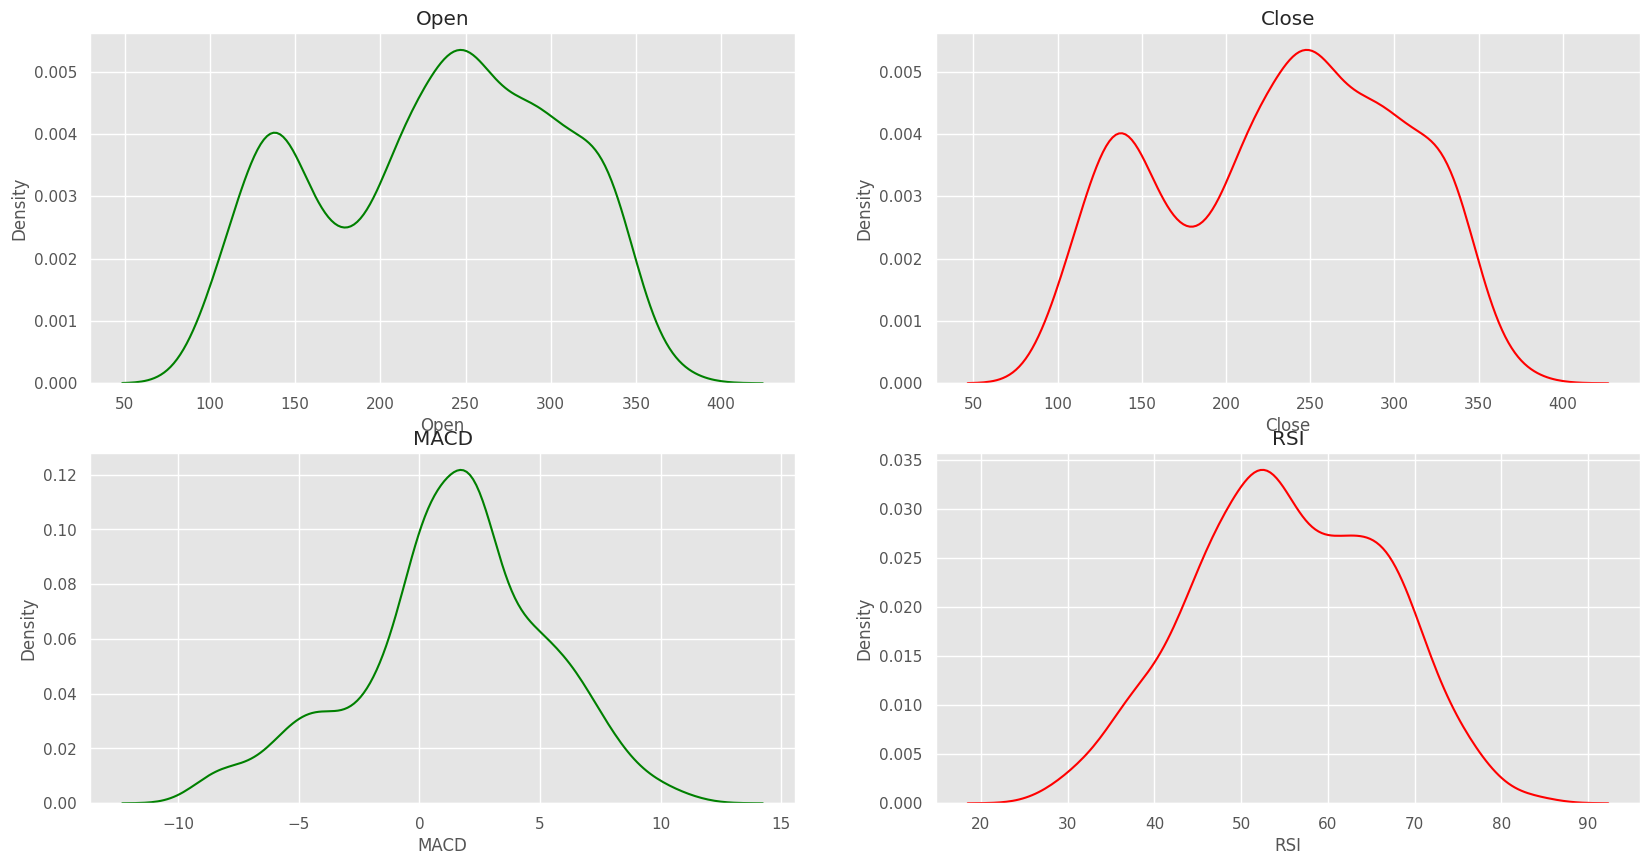

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE-Plots
plt.figure(figsize=(20,10))
#Plot 1
plt.subplot(2,2,1)
sns.kdeplot(dataset['Open'], color='green')
plt.title('Open')
#Plot 2
plt.subplot(2,2,2)
sns.kdeplot(dataset['Close'], color='red')
plt.title('Close')
#Plot 3
plt.subplot(2,2,3)
sns.kdeplot(dataset['MACD'], color='green')
plt.title('MACD')
#Plot 4
plt.subplot(2,2,4)
sns.kdeplot(dataset['RSI'], color='red')
plt.title('RSI')

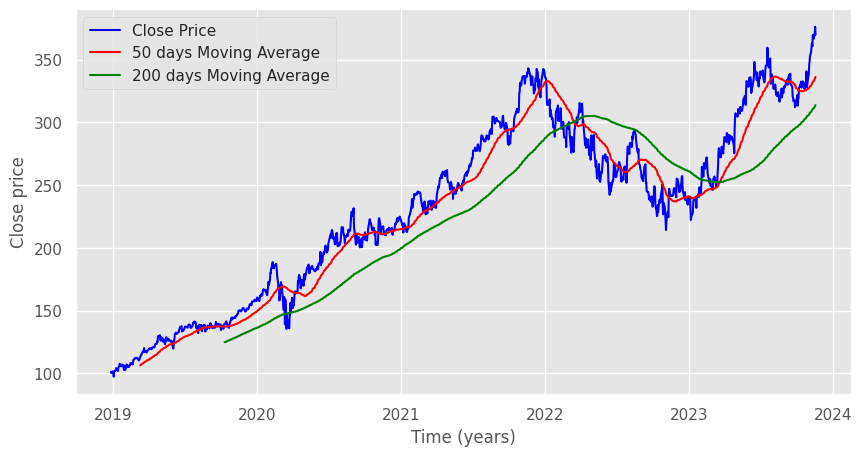

In [26]:
fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(dataset['Close'], 'blue')
plt.plot(dataset['Close'].rolling(50).mean(),'red')
plt.plot(dataset['Close'].rolling(200).mean(),'green')
plt.legend(['Close Price', '50 days Moving Average', '200 days Moving Average'], loc='upper left')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
plt.show()

<Figure size 2000x1500 with 0 Axes>

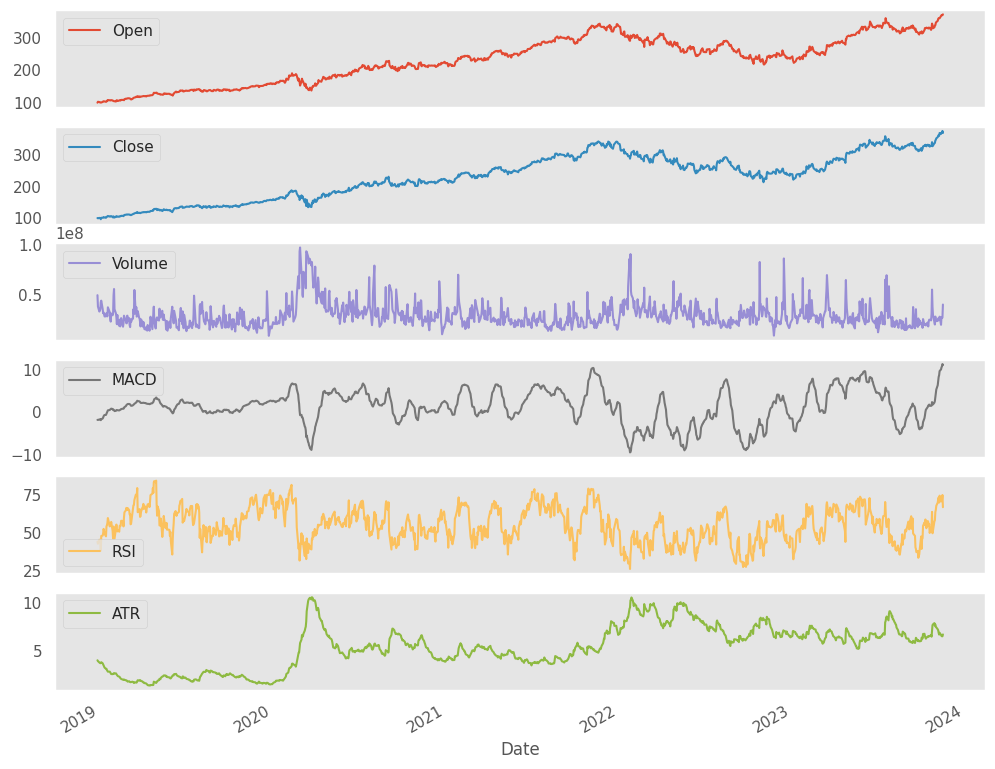

In [27]:
fig = plt.figure(figsize = (20, 15))
dataset.plot(subplots = True, figsize = (12,10), grid=False)
sns.set_style("whitegrid")
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [61]:
print(adf_test(dataset['Close']))

Results of Dickey-Fuller Test:
Test Statistic                   -0.871496
p-value                           0.797214
#Lags Used                        9.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64
None


In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_normalized = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

## Prepare test and train data

### Create sequences of data for training

In [31]:
X = []
y = []
time_step = 100
for i in range(len(close_normalized) - time_step):
        X.append(close_normalized[i : i + time_step])
        y.append(close_normalized[i + time_step])

X = np.array(X)
y = np.array(y)

### Splitting training, validation and test data

In [32]:
test_size = 0.2
valid_size = 0.2

train_pivot = int(len(X) * (1 - (valid_size + test_size)))
valid_pivot = train_pivot + int(len(X) * (valid_size))
X_train, X_valid, X_test = X[:train_pivot], X[train_pivot:valid_pivot], X[valid_pivot:]
y_train, y_valid, y_test = y[:train_pivot], y[train_pivot:valid_pivot], y[valid_pivot:]

In [40]:
def calculate_loss(model):
  train_loss = model.evaluate(X_train, y_train, verbose=1)
  valid_loss = model.evaluate(X_valid, y_valid, verbose=1)
  test_loss = model.evaluate(X_test, y_test, verbose=1)
  return train_loss, valid_loss, test_loss

In [41]:
def predict(model):
  train_predictions = model.predict(X_train)
  valid_predictions = model.predict(X_valid)
  test_predictions = model.predict(X_test)
  return train_predictions, valid_predictions, test_predictions

In [42]:
def inverse(data):
  return scaler.inverse_transform(data)

In [43]:
def plot_actual_predict_data(train_prediction, valid_prediction, test_prediction, title):
  plt.figure(figsize=(12, 6))
  plt.plot(dataset.index, dataset['Close'], label='Actual Prices', color='blue')
  plt.plot(dataset.index[time_step:len(train_prediction) + time_step], train_prediction, label='Predicted Training Prices', color='orange')
  plt.plot(dataset.index[len(train_prediction) + time_step:-len(test_prediction)], valid_prediction, label="Predicted Validation Prices", color="green")
  plt.plot(dataset.index[-len(test_prediction):], test_prediction, label='Predicted Test Prices', color='red')
  plt.title(title)
  plt.xlabel('Date (Years)')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

In [44]:
def rmse(y, y_pred):
  return math.sqrt(mean_squared_error(y, y_pred))

In [45]:
def mape(y, y_pred):
  return mean_absolute_percentage_error(y, y_pred)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True,
                   input_shape=(100, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning10')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history=best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)

Trial 5 Complete [00h 00m 45s]
val_loss: 0.002485973061993718

Best val_loss So Far: 0.001740562031045556
Total elapsed time: 00h 03m 15s
Best Hyperparameters:
Units: 32
Optimizer: rmsprop
Learning Rate: 0.003605420810659384
Batch Size: 96
Epoch 1/100
8/8 [==============================] - 5s 198ms/step - loss: 0.1250 - val_loss: 0.0175
Epoch 2/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0091 - val_loss: 0.0022
Epoch 3/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 4/100
8/8 [==============================] - 1s 89ms/step - loss: 0.0063 - val_loss: 0.0340
Epoch 5/100
8/8 [==============================] - 1s 88ms/step - loss: 0.0146 - val_loss: 0.0409
Epoch 6/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0093 - val_loss: 0.0174
Epoch 7/100
8/8 [==============================] - 1s 88ms/step - loss: 0.0112 - val_loss: 0.0028
Epoch 8/100
8/8 [==============================] - 1s 88ms/step - loss: 0

In [46]:
train_loss, valid_loss, test_loss = calculate_loss(best_model)
print(f'Training Loss: {train_loss},\nValidation Loss: {valid_loss}\nTesting Loss: {test_loss}')

8/8 [==============================] - 0s 26ms/step - loss: 8.6093e-04
Training Loss: 0.0004791422397829592,
Validation Loss: 0.0016408876981586218
Testing Loss: 0.0008609261130914092


In [47]:
train_prediction, valid_prediction, test_prediction = predict(best_model)

8/8 [==============================] - 0s 15ms/step


In [48]:
train_prediction, valid_prediction, test_prediction = inverse(train_prediction), inverse(valid_prediction), inverse(test_prediction)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [62]:
train_rmse = rmse(y_train_actual, train_prediction)
valid_rmse = rmse(y_valid_actual, valid_prediction)
test_rmse = rmse(y_test_actual, test_prediction)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 6.1020855359252835
Validation Root Mean Squared Error: 11.292377664554957
Testing Root Mean Squared Error: 8.179539969683331


In [63]:
train_mape = mape(y_train_actual, train_prediction)
valid_mape = mape(y_valid_actual, valid_prediction)
test_mape = mape(y_test_actual, test_prediction)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.021079935649492215
Validation Mean Absolute Percentage Error: 0.03472004781463105
Testing Mean Absolute Percentage Error: 0.021069152314096673


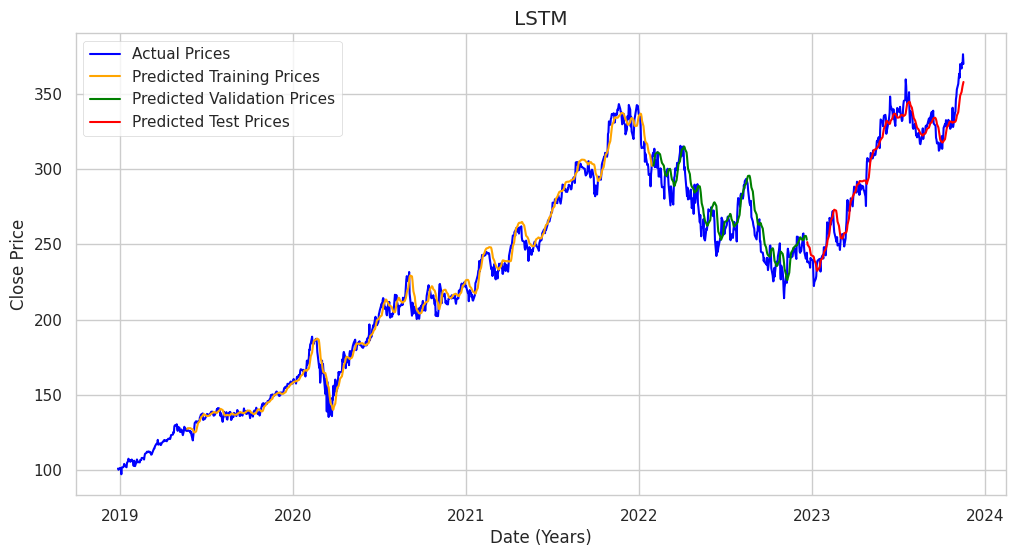

In [49]:
plot_actual_predict_data(train_prediction, valid_prediction, test_prediction, "LSTM")

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model1(hp):
    model1 = Sequential()
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        return_sequences=True,
                        input_shape=(100, 1)))
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        return_sequences=True))
    model1.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model1.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model1.compile(loss='mean_squared_error', optimizer=optimizer)
    return model1

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model1,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='rnn_hyperparameter_tuning')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

# Get the best hyperparameters
best_hps1 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps1.get('units')}")
print(f"Optimizer: {best_hps1.get('optimizer')}")
print(f"Learning Rate: {best_hps1.get('learning_rate')}")
print(f"Batch Size: {best_hps1.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model1 = tuner.hypermodel.build(best_hps1)
history1 = best_model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)


Trial 5 Complete [00h 00m 14s]
val_loss: 0.004350525792688131

Best val_loss So Far: 0.001060759648680687
Total elapsed time: 00h 01m 03s
Best Hyperparameters:
Units: 64
Optimizer: adam
Learning Rate: 0.0010140092234766135
Batch Size: 32
Epoch 1/100
8/8 [==============================] - 2s 86ms/step - loss: 0.2317 - val_loss: 0.0025
Epoch 2/100
8/8 [==============================] - 0s 51ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/100
8/8 [==============================] - 0s 52ms/step - loss: 9.4919e-04 - val_loss: 0.0021
Epoch 6/100
8/8 [==============================] - 1s 70ms/step - loss: 7.8323e-04 - val_loss: 0.0018
Epoch 7/100
8/8 [==============================] - 1s 88ms/step - loss: 7.7190e-04 - val_loss: 0.0038
Epoch 8/100
8/8 [==============================] - 1s 88ms/step 

In [51]:
train_loss1, valid_loss1, test_loss1 = calculate_loss(best_model1)
print(f'Training Loss: {train_loss1},\nValidation Loss: {valid_loss1}\nTesting Loss: {test_loss1}')

8/8 [==============================] - 0s 24ms/step - loss: 7.8678e-04
Training Loss: 0.00034374912502244115,
Validation Loss: 0.0009272903553210199
Testing Loss: 0.0007867759559303522


In [52]:
train_prediction1, valid_prediction1, test_prediction1 = predict(best_model1)

8/8 [==============================] - 0s 9ms/step


In [53]:
train_prediction1, valid_prediction1, test_prediction1 = inverse(train_prediction1), inverse(valid_prediction1), inverse(test_prediction1)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [64]:
train_rmse = rmse(y_train_actual, train_prediction1)
valid_rmse = rmse(y_valid_actual, valid_prediction1)
test_rmse = rmse(y_test_actual, test_prediction1)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 5.168527642710614
Validation Root Mean Squared Error: 8.488949138196649
Testing Root Mean Squared Error: 7.819366824768958


In [65]:
train_mape = mape(y_train_actual, train_prediction1)
valid_mape = mape(y_valid_actual, valid_prediction1)
test_mape = mape(y_test_actual, test_prediction1)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.01799182796509111
Validation Mean Absolute Percentage Error: 0.026095363711380423
Testing Mean Absolute Percentage Error: 0.020160347569719482


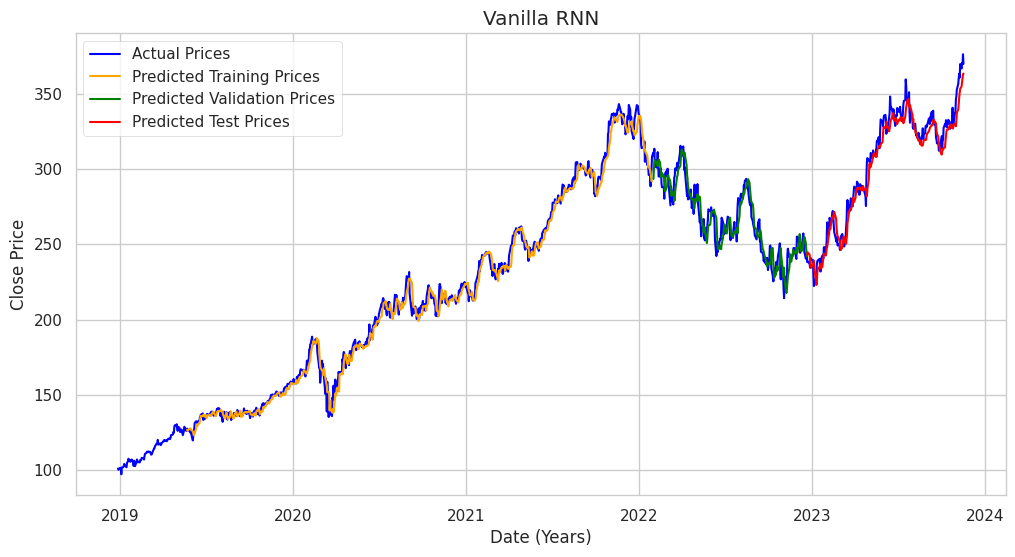

In [54]:
plot_actual_predict_data(train_prediction1, valid_prediction1, test_prediction1, "Vanilla RNN")

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import numpy as np

hp = HyperParameters()

def build_model2(hp):
    model2 = Sequential()
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True,
                   input_shape=(100, 1)))
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True))
    model2.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model2.add(Dense(1))

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    # Set batch_size as a hyperparameter
    batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    model2.compile(loss='mean_squared_error', optimizer=optimizer)
    return model2

# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model2,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='gru_hyperparameter_tuning')

# Start the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

# Get the best hyperparameters
best_hps2 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Units: {best_hps2.get('units')}")
print(f"Optimizer: {best_hps2.get('optimizer')}")
print(f"Learning Rate: {best_hps2.get('learning_rate')}")
print(f"Batch Size: {best_hps2.get('batch_size')}")

# Build the model with the best hyperparameters and train it
best_model2 = tuner.hypermodel.build(best_hps)
history2 = best_model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=best_hps.get('batch_size'), verbose=1)


Trial 5 Complete [00h 00m 45s]
val_loss: 0.0008197108982130885

Best val_loss So Far: 0.0005132963415235281
Total elapsed time: 00h 02m 57s
Best Hyperparameters:
Units: 96
Optimizer: adam
Learning Rate: 0.005379471191869606
Batch Size: 128
Epoch 1/100
8/8 [==============================] - 5s 185ms/step - loss: 0.0605 - val_loss: 0.0073
Epoch 2/100
8/8 [==============================] - 1s 99ms/step - loss: 0.0095 - val_loss: 0.0129
Epoch 3/100
8/8 [==============================] - 1s 136ms/step - loss: 0.0127 - val_loss: 0.0189
Epoch 4/100
8/8 [==============================] - 1s 133ms/step - loss: 0.0074 - val_loss: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 96ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 6/100
8/8 [==============================] - 1s 88ms/step - loss: 0.0120 - val_loss: 0.0301
Epoch 7/100
8/8 [==============================] - 1s 85ms/step - loss: 0.0077 - val_loss: 0.0023
Epoch 8/100
8/8 [==============================] - 1s 86ms/step - loss:

In [55]:
train_loss2, valid_loss2, test_loss2 = calculate_loss(best_model2)
print(f'Training Loss: {train_loss2},\nValidation Loss: {valid_loss2}\nTesting Loss: {test_loss2}')

8/8 [==============================] - 0s 12ms/step - loss: 6.3492e-04
Training Loss: 0.00034853711258620024,
Validation Loss: 0.0006628782139159739
Testing Loss: 0.0006349214818328619


In [56]:
train_prediction2, valid_prediction2, test_prediction2 = predict(best_model2)

8/8 [==============================] - 0s 15ms/step


In [57]:
train_prediction2, valid_prediction2, test_prediction2 = inverse(train_prediction2), inverse(valid_prediction2), inverse(test_prediction2)
y_train_actual, y_valid_actual, y_test_actual = inverse(y_train.reshape(-1, 1)), inverse(y_valid.reshape(-1, 1)), inverse(y_test.reshape(-1, 1))

In [66]:
train_rmse = rmse(y_train_actual, train_prediction2)
valid_rmse = rmse(y_valid_actual, valid_prediction2)
test_rmse = rmse(y_test_actual, test_prediction2)
print(f'Training Root Mean Squared Error: {train_rmse}')
print(f'Validation Root Mean Squared Error: {valid_rmse}')
print(f'Testing Root Mean Squared Error: {test_rmse}')

Training Root Mean Squared Error: 5.2043996787615034
Validation Root Mean Squared Error: 7.177329358883935
Testing Root Mean Squared Error: 7.024346534026787


In [67]:
train_mape = mape(y_train_actual, train_prediction2)
valid_mape = mape(y_valid_actual, valid_prediction2)
test_mape = mape(y_test_actual, test_prediction2)
print(f'Training Mean Absolute Percentage Error: {train_mape}')
print(f'Validation Mean Absolute Percentage Error: {valid_mape}')
print(f'Testing Mean Absolute Percentage Error: {test_mape}')

Training Mean Absolute Percentage Error: 0.02110877024921658
Validation Mean Absolute Percentage Error: 0.022294147001930054
Testing Mean Absolute Percentage Error: 0.01801309595124932


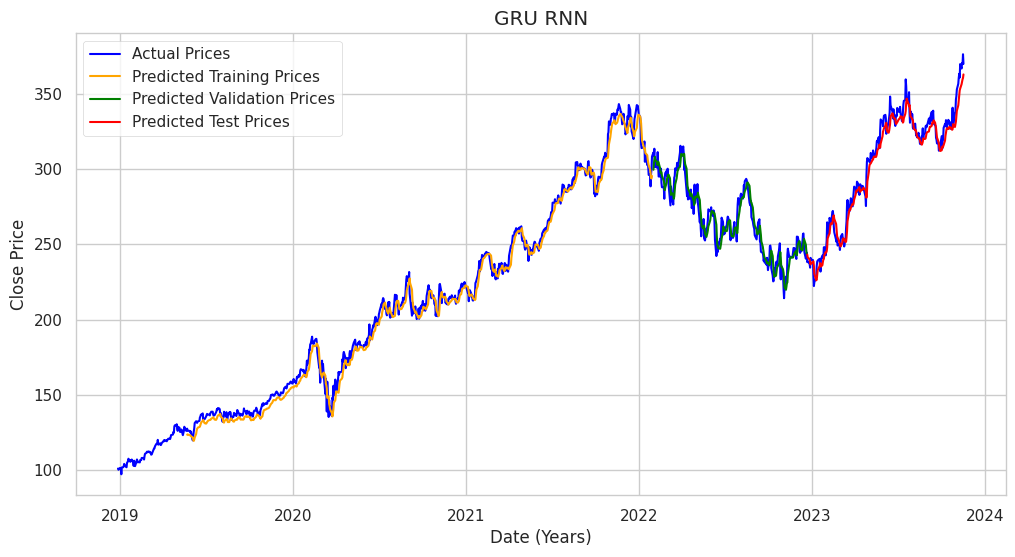

In [58]:
plot_actual_predict_data(train_prediction2, valid_prediction2, test_prediction2, "GRU RNN")